In [23]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env") #! needed t osolve an Action issue

Local environment
Added the following directory to the PYTHONPATH: /home/alvart/MLScalable/mlfs-book
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [31]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [26]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 
#could have read these from the env file bu t we do from hopsworks bcus its easier
secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-13 17:57:11,817 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-13 17:57:11,911 INFO: Initializing external client
2025-11-13 17:57:11,912 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-13 17:57:13,467 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279167


In [32]:
# Retrieve feature groups (made in nb1)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1, #we also have a ver 2 actually
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [33]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])
#what we actually do here is: select the rows w columns pm25 and data and features of wather_fg which have matching city as the air_qual rows.

#we actually dont train on the date feature data but we will need it anyways later for plotting/graphing by time
#select_features() chooses the feats (not index columns (primary key and event time))

2025-11-13 18:02:20,330 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [37]:
#makes sure the same data is used in both training and inference. Fv isbasically storing label/targets and relevant features we can query later in training/inference
#we will later in train/inference  query FV which then tells what to get from the fg it depends on.
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=2,
    labels=['pm25'], #labels/targets for training
    query=selected_features, #all available columns (both  input feats and label)
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [38]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [39]:
#evrything b4 test_data_start_date will be for train data
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)
#remember that y are the labels and x contains the features

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.49s) 


In [47]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2017-10-04 00:00:00+00:00,10.587333,2.9,22.206486,248.656326
1,2017-10-04 00:00:00+00:00,10.587333,2.9,22.206486,248.656326
2,2017-10-05 00:00:00+00:00,8.433167,2.6,16.595179,306.521240
3,2017-10-05 00:00:00+00:00,8.433167,2.6,16.595179,306.521240
4,2017-10-06 00:00:00+00:00,8.247749,0.5,23.871555,320.408325
...,...,...,...,...,...
5378,2025-04-28 00:00:00+00:00,11.935249,0.1,25.084663,258.606140
5379,2025-04-29 00:00:00+00:00,11.904000,0.0,20.170443,301.991791
5380,2025-04-29 00:00:00+00:00,11.904000,0.0,20.170443,301.991791
5381,2025-04-30 00:00:00+00:00,8.947750,1.6,25.369785,313.522400


In [42]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [45]:
X_test


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
5383,2025-05-01 00:00:00+00:00,8.199834,0.3,14.495310,188.917404
5384,2025-05-01 00:00:00+00:00,8.199834,0.3,14.495310,188.917404
5385,2025-05-02 00:00:00+00:00,11.412334,3.8,26.282465,236.262527
5386,2025-05-02 00:00:00+00:00,11.412334,3.8,26.282465,236.262527
5387,2025-05-03 00:00:00+00:00,10.231084,0.2,17.762634,291.810120
...,...,...,...,...,...
5766,2025-11-09 00:00:00+00:00,5.843584,0.8,12.168319,260.668640
5767,2025-11-10 00:00:00+00:00,5.662334,0.7,7.970972,15.767236
5768,2025-11-11 00:00:00+00:00,5.854000,0.0,9.860649,199.362671
5769,2025-11-12 00:00:00+00:00,7.910250,4.0,28.339569,206.015747


In [48]:
y_train

,pm25
0,13.0
1,13.0
2,9.0
3,9.0
4,8.0
...,...
5378,28.0
5379,12.0
5380,14.0
5381,18.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [50]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

#ofc we can set and finetune hyperparams to improve perfromance but baseline should work for now.

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [51]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 141.86613
R squared: -0.2745598418065256


In [52]:
df = y_test #copies your test labels into a new DataFrame
df['predicted_pm25'] = y_pred #Adds a new column to df called "predicted_pm25", containing the model’s predicted values.

In [55]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)
#the pm25 column is from the y_test data

,pm25,predicted_pm25,date
5383,18.0,34.640690,2025-05-01 00:00:00+00:00
5384,20.0,34.640690,2025-05-01 00:00:00+00:00
5385,19.0,18.719349,2025-05-02 00:00:00+00:00
5386,21.0,18.719349,2025-05-02 00:00:00+00:00
5387,10.0,14.955388,2025-05-03 00:00:00+00:00


In [57]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

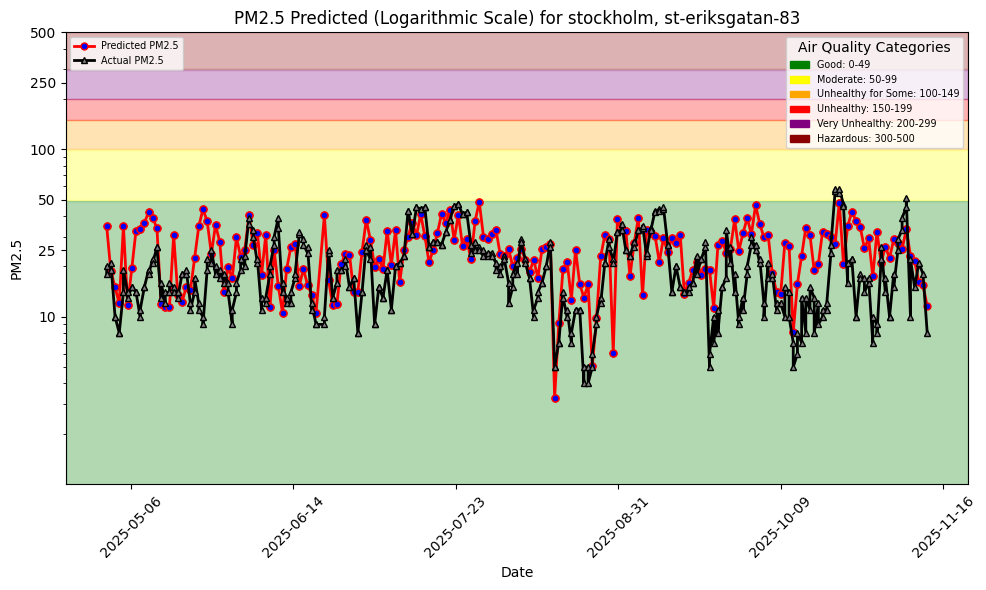

In [58]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

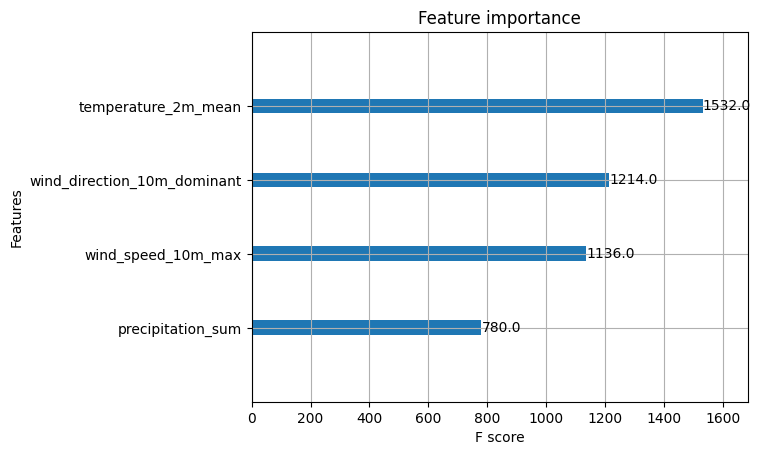

In [59]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [60]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [61]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [62]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'
#there are also versions scikitLearn and LLM model option and so on
aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/alvart/MLScalable/mlfs-book/notebooks/airquality/air_quality_model/model.json: 0.000%|        …

Uploading /home/alvart/MLScalable/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance.p…

Uploading /home/alvart/MLScalable/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast.png: 0…

Uploading /home/alvart/MLScalable/mlfs-book/notebooks/airquality/model_schema.json: 0.000%|          | 0/572 e…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279167/models/air_quality_xgboost_model/2


Model(name: 'air_quality_xgboost_model', version: 2)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
